In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import czt, convolve2d
from scipy.fft import fft2, fftshift, fftfreq
from scipy.special import jn

from lifesim.util.radiation import black_body

# Figure 2: Understanding the Nulling Response through Symmetry

This notebook simulates and analyzes the Fourier transform of astronomical sources, including exozodiacal light, stars, and planets, based on their symmetry. It includes functions for generating 2D representations of these sources and visualizations of their Fourier-transformed data.


In [2]:
# from https://github.com/pahuber/PyWaveFilters/blob/main/pywavefilters/util/math.py
def get_2d_chirp_z_transform(complex_amplitude: np.ndarray, grid_size: int,
                             maximum_frequency: int) -> np.ndarray:
    """
    Method to calculate the 2-dimensional chirp z-transform using scipy.signal.czt. As found on
    https://stackoverflow.com/questions/30791905/zoom-in-on-np-fft2-result

            Parameters:
                    complex_amplitude: Complex amplitude of the Basewavefront object
                    grid_size: Grid size
                    maximum_frequency: Maximum frequency used for the transform

            Returns:
                    Transformed complex amplitude
    """

    width, height = complex_amplitude.shape
    aw = 2j * maximum_frequency / ((grid_size - 1) * width)

    f1 = czt(complex_amplitude, m=grid_size, w=np.exp(aw),
             a=np.exp(0.5 * (grid_size - 1) * aw),
             axis=0)
    data = f1 * np.exp(
        -0.5j * maximum_frequency * np.linspace(-1, 1, grid_size))[:,
                np.newaxis]
    ah = 2j * maximum_frequency / ((grid_size - 1) * height)
    f2 = czt(data, m=grid_size, w=np.exp(ah),
             a=np.exp(0.5 * (grid_size - 1) * ah), axis=1)

    transformed_complex_amplitude = f2 * np.exp(
        -0.5j * maximum_frequency * np.linspace(-1, 1, grid_size))[
                                         np.newaxis, :]

    return transformed_complex_amplitude

# 1. Source Setup
This section outlines the setup process for simulating different astronomical sources, such as exozodiacal light, stars, and planets. These source representations are utilized for calculating their Fourier Transform as part of analyzing their symmetry properties when observed using astronomical instruments.


**This cell defines three functions:**

1. `create_exozodi_2d`: Generates a 2D map representing exozodiacal dust emission, computes its Fourier transform, and models the observational effects of a telescope, such as an aperture mask.

2. `create_star_2d`: Simulates a 2D Fourier-transformed intensity map for a star, considering black body radiation, angular size, and baseline frequencies.

3. `create_planet_2d`: Simulates the Fourier signal for a planet using its angular separation and position angle.

These functions are critical for modeling astronomical sources and their Fourier-transformed data, which is key to analyzing symmetry properties in astrophysical observations.

In [3]:
def create_exozodi_2d(l_sun: float,
                      z: float,
                      image_size: int,
                      wl_bins: np.ndarray,
                      wl_bin_widths: np.ndarray,
                      diameter_ap: float,
                      dist_star: float) -> tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    This function creates a 2D map representing the exozodiacal dust emission
    that can be used for astrophysical simulations. It takes into account the
    parameters describing the stellar system and the observational setup, such
    as stellar luminosity, zodiacal light scaling factor, instrument parameters,
    and distances, and computes the dust distribution and its associated black
    body spectral emission. The function also simulates the observational effects
    of the telescope, including the Fourier transform of the signal and the
    effect of an aperture mask.

    :param l_sun: Stellar luminosity in Solar units
    :type l_sun: float
    :param z: Zodiacal light scaling factor, representing the dust density scaling
    :type z: float
    :param image_size: Size of the simulation image in pixels
    :type image_size: int
    :param wl_bins: Wavelength bins for the spectrum, in microns
    :type wl_bins: numpy.ndarray
    :param wl_bin_widths: Widths of each wavelength bin, in microns
    :type wl_bin_widths: numpy.ndarray
    :param diameter_ap: Diameter of the observing telescope's aperture, in meters
    :type diameter_ap: float
    :param dist_star: Distance to the target star, in parsecs
    :type dist_star: float
    :return: A tuple consisting of:
        - The Fourier-transformed 2D exozodiacal intensity map
          (numpy.ndarray)
        - The spatial frequency response of the aperture mask (numpy.ndarray)
        - The convolved Fourier-transformed 2D intensity map after considering
          the aperture mask (numpy.ndarray)
        - The spatial frequency grid (numpy.ndarray)
    :rtype: tuple

    """
    hfov = wl_bins / (2. * diameter_ap)

    hfov_mas = hfov * (3600000. * 180.) / np.pi
    rad_pix = (2 * hfov) / image_size  # Radians per pixel
    mas_pix = (2 * hfov_mas) / image_size  # mas per pixel
    au_pix = mas_pix / 1e3 * dist_star  # AU per pixel

    x_map = np.tile(np.array(range(0, image_size)),
                    (image_size, 1))
    y_map = x_map.T
    r_square_map = ((x_map - (image_size - 1) / 2) ** 2
                    + (y_map - (image_size - 1) / 2) ** 2)
    radius_map = np.sqrt(r_square_map)
    r_au = (radius_map[np.newaxis, :, :]
            * au_pix[:, np.newaxis, np.newaxis])

    # calculate the parameters required by Kennedy2015
    alpha = 0.34
    r_in = 0.034422617777777775 * np.sqrt(l_sun)
    r_0 = np.sqrt(l_sun)
    # Sigma_{m,0} from Kennedy+2015 (doi:10.1088/0067-0049/216/2/23)
    sigma_zero = 7.11889e-8

    # identify all pixels where the radius is larges than the inner radius by
    # Kennedy+2015
    # r_cond = ((r_au >= r_in)
    #           & (r_au <= image_size / 2 * au_pix[:, np.newaxis, np.newaxis]))
    r_cond = (r_au <= image_size / 2 * au_pix[:, np.newaxis, np.newaxis])

    # calculate the temperature at all pixel positions according to Eq. 2 in
    # Kennedy2015
    temp_map = np.where(r_cond,
                        np.divide(278.3 * (l_sun ** 0.25), np.sqrt(r_au),
                                  out=np.zeros_like(r_au),
                                  where=(r_au != 0.)),
                        0)

    # calculate the Sigma (Eq. 3) in Kennedy2015 and set everything inside the
    # inner radius to 0
    sigma = np.where(r_cond,
                     sigma_zero * z *
                     np.power(r_au / r_in, -alpha,
                              out=np.zeros_like(r_au),
                              where=(r_au != 0.)),
                     0)

    # get the black body radiation emitted by the interexoplanetary dust
    f_nu_disk = black_body(bins=wl_bins[:, np.newaxis, np.newaxis],
                           width=wl_bin_widths[:, np.newaxis, np.newaxis],
                           temp=temp_map,
                           mode='wavelength') \
                * sigma * rad_pix[:, np.newaxis, np.newaxis] ** 2

    ap = np.where(radius_map <= image_size / 2, 1, 0)
    flux_map_exozodi = f_nu_disk * ap

    exozodi_ft = get_2d_chirp_z_transform(flux_map_exozodi[0], image_size,
                                          image_size * np.pi)
    exozodi_freq = fftshift(fftfreq(image_size, rad_pix[0])) * wl_bins[0]

    bl = np.meshgrid(exozodi_freq, exozodi_freq)

    # angular extend of the star disk in rad divided by 2 to get radius
    ang_star = r_in / dist_star * np.pi / (180 * 3600)
    bl_mat = (bl[0] ** 2 + bl[1] ** 2) ** 0.5
    b_hole = np.nan_to_num(
        np.divide(2 * jn(1, 2 * np.pi * bl_mat[np.newaxis, :] * ang_star
                         / wl_bins[:, np.newaxis, np.newaxis]),
                  2 * np.pi * bl_mat[np.newaxis, :] * ang_star
                  / wl_bins[:, np.newaxis, np.newaxis]))[0]  # Eq (11)

    exozodi_ft_final = convolve2d(exozodi_ft, b_hole, mode='same')

    return exozodi_ft, b_hole, exozodi_ft_final, exozodi_freq


def create_star_2d(wl_bins: np.ndarray,
                   wl_bin_widths: np.ndarray,
                   temp_star: float,
                   radius_star: float,
                   dist_star: float,
                   max_bl: float,
                   image_size: int) -> np.ndarray:
    """
    Generate a 2D intensity distribution of a star based on its physical properties 
    and observational parameters. The function calculates the star's flux using a 
    black body radiation model, computes angular size, and utilizes the 
    Bessel function to model the star's intensity in a 2D grid.

    :param wl_bins: Array of wavelength bins in micrometers.
    :type wl_bins: numpy.ndarray
    :param wl_bin_widths: Array of wavelength bin widths corresponding to `wl_bins`.
    :type wl_bin_widths: numpy.ndarray
    :param temp_star: Temperature of the star in Kelvin.
    :type temp_star: float
    :param radius_star: Radius of the star in solar radii (R☉).
    :type radius_star: float
    :param dist_star: Distance to the star in parsecs.
    :type dist_star: float
    :param max_bl: Maximum baseline size used for the grid, in meters.
    :type max_bl: float
    :param image_size: Size of the 2D output grid (number of pixels per dimension).
    :type image_size: int
    :return: 2D intensity distribution of the star for the first wavelength bin.
    :rtype: numpy.ndarray
    """
    flux_star = black_body(mode='star',
                           bins=wl_bins,
                           width=wl_bin_widths,
                           temp=temp_star,
                           radius=radius_star,
                           distance=dist_star)

    bl_x = np.linspace(-max_bl, max_bl, image_size)
    bl_y = np.linspace(-max_bl, max_bl, image_size)
    bl = np.array(np.meshgrid(bl_x, bl_y))

    # angular extend of the star disk in rad divided by 2 to get radius
    ang_star = radius_star * 0.00465 / dist_star * np.pi / (180 * 3600)
    bl_mat = (bl[0] ** 2 + bl[1] ** 2) ** 0.5
    b_star = np.nan_to_num(
        np.divide(
            2 * flux_star[:, np.newaxis, np.newaxis]
            * jn(1, 2 * np.pi * bl_mat[np.newaxis, :] * ang_star
                 / wl_bins[:, np.newaxis, np.newaxis]),
            2 * np.pi * bl_mat[np.newaxis, :] * ang_star
            / wl_bins[:, np.newaxis, np.newaxis]))  # Eq (11)

    return b_star[0]


def create_planet_2d(angsep: float,
                     angle_p: float,
                     image_size: int,
                     wl_bins: float,
                     max_bl: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate a 2D representation of planetary signals.

    This function creates two 2D arrays representing the sine and cosine signals of
    a planet based on its angular separation, position angle, and other given properties.
    The signals are calculated using the baseline and given wavelength bins. The output
    is a tuple containing the cosine and sine signal arrays.

    :param angsep: Angular separation of the planet in arcseconds.
    :param angle_p: Position angle of the planet in radians.
    :param image_size: Size of the 2D image grid (number of pixels per row/column).
    :param wl_bins: Wavelength bin size used in the calculation.
    :param max_bl: Maximum baseline length for the image grid.
    :return: A tuple of two numpy arrays:
             - First array represents cosine signals (sig_as).
             - Second array represents sine signals (sig_s).
    """
    theta_p = angsep * np.array((np.cos(angle_p), np.sin(angle_p))) * np.pi / (
                180 * 3600)

    bl = np.array(np.meshgrid(
        np.linspace(-max_bl, max_bl, image_size),
        np.linspace(-max_bl, max_bl, image_size)
    ))

    sig_as = np.cos(2 * np.pi * (
                theta_p[0] * bl[0, :, :] + theta_p[1] * bl[1, :, :]) / wl_bins)
    sig_s = np.sin(2 * np.pi * (
                theta_p[0] * bl[0, :, :] + theta_p[1] * bl[1, :, :]) / wl_bins)

    return sig_as, sig_s
    

# 2. Create sources and fourier transform

This code generates a 2D representation of exozodiacal light emission (`exozodi`), its Fourier transform (`exozodi_ft`), and baseline grids (`bl`), using specified parameters for stellar luminosity, aperture diameter, distance, and wavelength bins.

In [4]:
image_size = int(512 / 2)
dist = 1.
exozodi, b_hole, exozodi_ft, bl = create_exozodi_2d(l_sun=1.0,
                                                    z=1,
                                                    image_size=image_size,
                                                    wl_bins=np.array([10e-6]),
                                                    wl_bin_widths=np.array(
                                                        [1e-6]),
                                                    diameter_ap=3.,
                                                    dist_star=dist)

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_8706/4201724342.py:108: RuntimeWarning: invalid value encountered in divide
  np.divide(2 * jn(1, 2 * np.pi * bl_mat[np.newaxis, :] * ang_star


This code generates a 2D Fourier-transformed intensity map (`star`) for a star based on specified parameters such as temperature, radius, distance, wavelength bins, and baseline grid size.

In [5]:
image_size = 512
max_bl = 120
star = create_star_2d(wl_bins=np.array([10e-6]),
                      wl_bin_widths=np.array([1e-6]),
                      temp_star=5800,
                      radius_star=1,
                      dist_star=dist,
                      max_bl=max_bl,
                      image_size=image_size)

This cell generates symmetric (`planet_s`) and anti-symmetric (`planet_as`) 2D Fourier-transformed maps for a planet using specified parameters such as angular separation (`angsep`), position angle (`angle_p`), grid size (`image_size`), wavelength bins (`wl_bins`), and maximum baseline length (`max_bl`).

In [6]:
planet_s, planet_as = create_planet_2d(angsep=0.1,
                                       angle_p=np.pi / 4,
                                       image_size=image_size,
                                       wl_bins=10e-6,
                                       max_bl=max_bl)

This code creates a 2D array `localzodi` filled with zeros, having the same shape as the `star` array.

In [7]:
localzodi = np.zeros_like(star)

# 3. Create the Final Plot

In this section, we generate and customize a set of visualizations comparing Fourier-transformed data for various astronomical sources. 

- **Subplot Creation**: 
  Five subplots are created side by side to compare the Fourier responses of `Star`, `Exo-zodi`, `Local-zodi`, and both symmetric and anti-symmetric `Planet` signals. The grids use logarithmic scaling for better visual clarity, and axes are labeled in terms of baseline coordinates.

- **Data Visualization**:
  - `Star` Fourier-transformed intensity is displayed in grayscale.
  - `Exo-zodi` and `Local-zodi` Fourier-transformed data are similarly visualized.
  - For `Planet`, symmetric (`planet_s`) and anti-symmetric (`planet_as`) signals are displayed with corresponding colormap settings.

- **Customization**:
  The plots are decorated with markers that denote key baseline locations for nulling and imaging. Different colors distinguish positive (`pmarkers`) and negative (`mmarkers`) nulling baselines.

- **Additional Formatting**:
  Titles, labels, and legends are crafted using LaTeX syntax. A dividing line visually distinguishes symmetric and anti-symmetric data to emphasize their symmetry properties.

The final plot showcases the comparative symmetry properties of the Fourier-transformed astrophysical data.



In [8]:
#Direct input
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

#Options
params = {'text.usetex': True,
          'font.size': 8,
          'font.family': 'lmodern',
          }

plt.rcParams.update(params)

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_8706/572251994.py:32: RuntimeWarning: divide by zero encountered in log10
  ax[2].imshow(np.log10(np.abs(localzodi)), cmap=cmap, extent=[np.min(bl), np.max(bl), np.min(bl), np.max(bl)], rasterized=True)


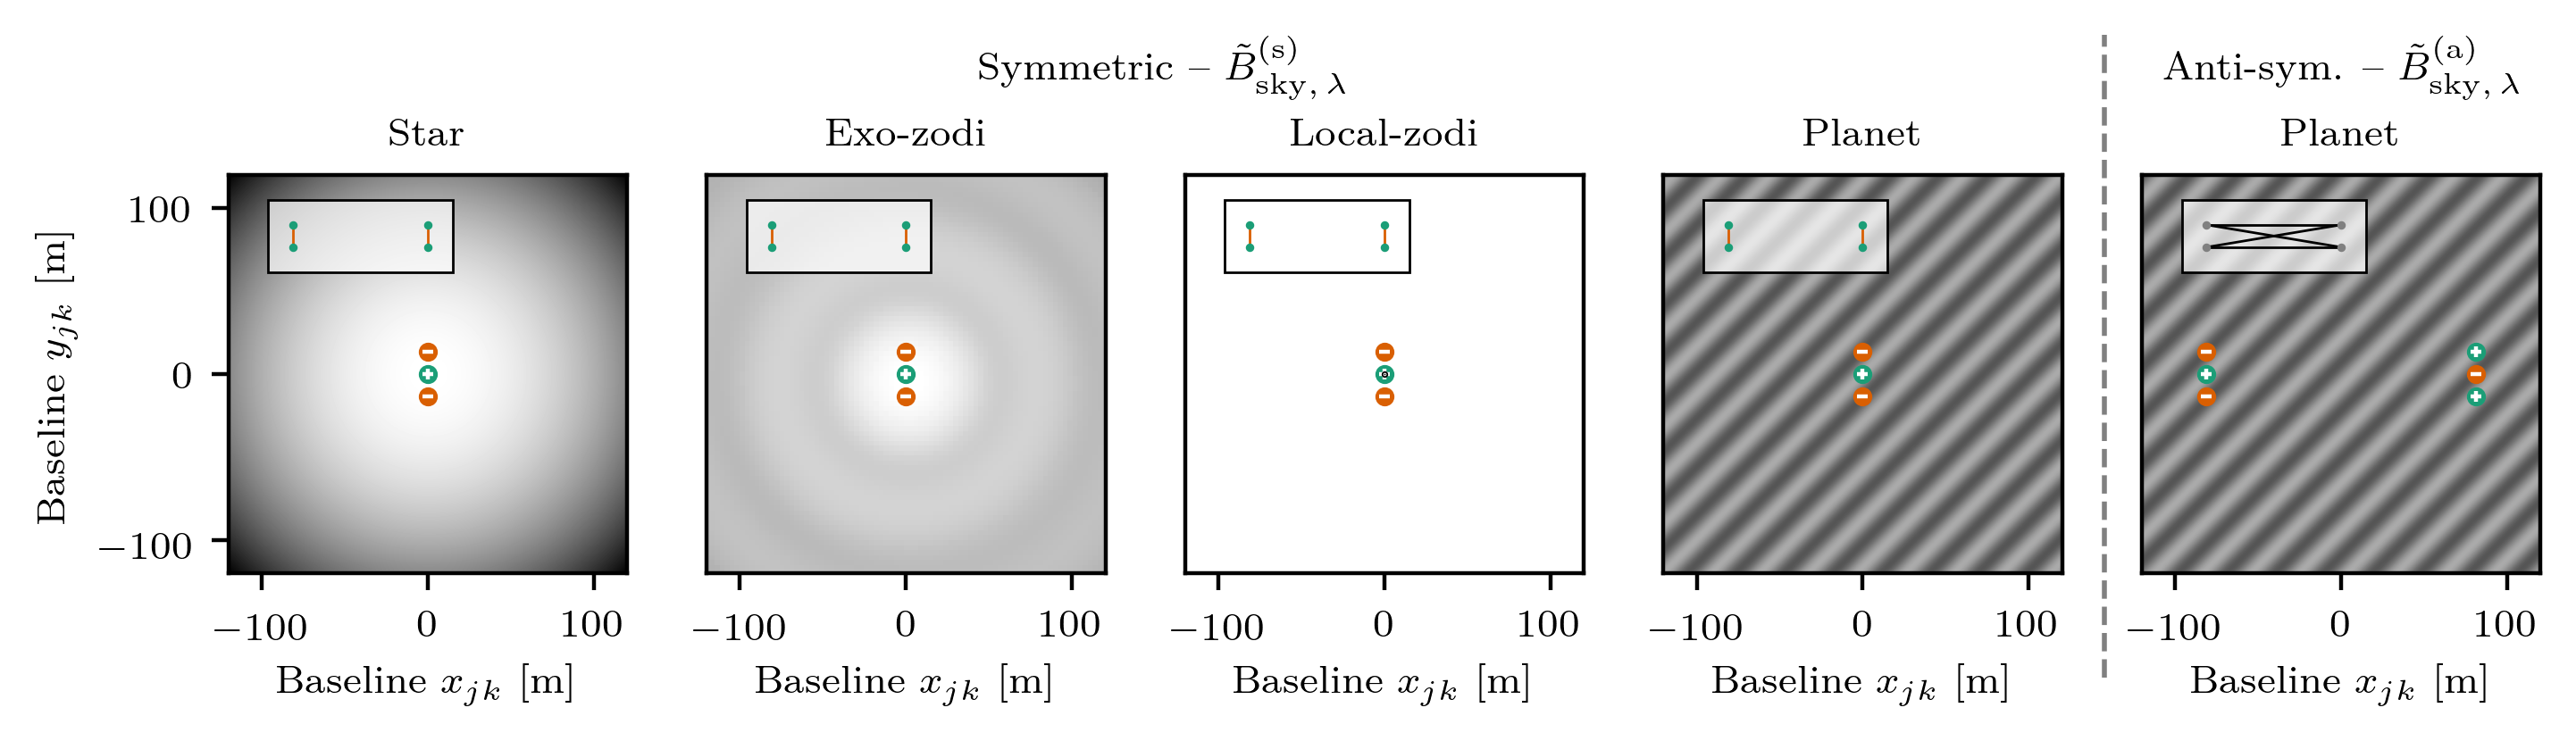

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(7.2708333, 2), dpi=400)

cmap = 'gray'
p_color = '#1b9e77'  # 'tab:blue'
m_color = '#d95f02'  # 'tab:red'

titles = ['Star', 'Exo-zodi', 'Local-zodi', 'Planet', 'Planet']

nulling_bl = 13.5
imaging_bl = nulling_bl * 6

pmarkers_s = [[0, 0]]
mmarkers_s = [[0, nulling_bl], [0, -nulling_bl]]

pmarkers_as = [[imaging_bl, nulling_bl], [imaging_bl, -nulling_bl],
               [-imaging_bl, 0]]
mmarkers_as = [[-imaging_bl, nulling_bl], [-imaging_bl, -nulling_bl],
               [imaging_bl, 0]]

smax = 3

ax[0].imshow(np.log10(np.abs(star)), cmap=cmap,
             extent=[-max_bl, max_bl, -max_bl, max_bl], rasterized=True)

ax[1].imshow(np.log10(np.abs(exozodi_ft)), cmap=cmap,
             extent=[np.min(bl), np.max(bl), np.min(bl), np.max(bl)],
             rasterized=True)

ax[2].imshow(np.log10(np.abs(localzodi)), cmap=cmap,
             extent=[np.min(bl), np.max(bl), np.min(bl), np.max(bl)],
             rasterized=True)

ax[3].imshow(planet_s, cmap=cmap, extent=[-max_bl, max_bl, -max_bl, max_bl],
             vmax=smax, vmin=-smax, rasterized=True)

ax[4].imshow(planet_as, cmap=cmap, extent=[-max_bl, max_bl, -max_bl, max_bl],
             vmax=smax, vmin=-smax, rasterized=True)

start = np.array([-imaging_bl, 90])

# nulling_bl *= 1.5
# imaging_bl *= 1.5

for i in range(5):
    if i != 4:
        ax[i].plot([start[0], start[0]],
                   [start[1], start[1] - nulling_bl],
                   color=m_color, lw=0.5, zorder=9)

        ax[i].plot([start[0] + imaging_bl, start[0] + imaging_bl],
                   [start[1], start[1] - nulling_bl],
                   color=m_color, lw=0.5, zorder=9)

        ax[i].scatter(
            [start[0], start[0] + imaging_bl, start[0] + imaging_bl, start[0]],
            [start[1], start[1], start[1] - nulling_bl, start[1] - nulling_bl],
            color=p_color, s=0.5, marker='o', zorder=10)
    else:
        ax[i].scatter(
            [start[0], start[0] + imaging_bl, start[0] + imaging_bl, start[0]],
            [start[1], start[1], start[1] - nulling_bl, start[1] - nulling_bl],
            color='gray', s=0.5, marker='o', zorder=10)

        ax[i].plot([start[0], start[0] + imaging_bl],
                   [start[1], start[1]],
                   color='k', lw=0.5, zorder=9)

        ax[i].plot([start[0], start[0] + imaging_bl],
                   [start[1] - nulling_bl, start[1] - nulling_bl],
                   color='k', lw=0.5, zorder=9)

        ax[i].plot([start[0], start[0] + imaging_bl],
                   [start[1], start[1] - nulling_bl],
                   color='k', lw=0.5, zorder=9)

        ax[i].plot([start[0], start[0] + imaging_bl],
                   [start[1] - nulling_bl, start[1]],
                   color='k', lw=0.5, zorder=9)

    # insert white transparent rectangle
    buffer = 15

    ax[i].add_patch(
        plt.Rectangle((start[0] - buffer, start[1] - nulling_bl - buffer),
                      imaging_bl + buffer * 2, nulling_bl + buffer * 2, fc='w',
                      alpha=0.7, zorder=5, ec=None))
    ax[i].add_patch(
        plt.Rectangle((start[0] - buffer, start[1] - nulling_bl - buffer),
                      imaging_bl + buffer * 2, nulling_bl + buffer * 2, ec='k',
                      fc='none', zorder=5, lw=0.5))

labelsize = 8
ms_out = 8
ms = 2

ax[0].set_ylabel(r'Baseline $y_{jk}$ [m]',
                 fontsize=labelsize
                 )
ax[0].set_yticks([-100, 0, 100])

for i in range(1, 5):
    ax[i].set_yticks([])

for i in range(5):
    ax[i].set_xlim(-max_bl, max_bl)
    ax[i].set_ylim(-max_bl, max_bl)
    ax[i].set_xlabel(r'Baseline $x_{jk}$ [m]',
                     fontsize=labelsize
                     )
    ax[i].set_title(titles[i],
                    fontsize=labelsize
                    )
    # set size of tick labels
    ax[i].tick_params(axis='both',
                      which='major',
                      labelsize=labelsize
                      )

for i in range(4):
    for pm in pmarkers_s:
        ax[i].scatter(pm[0], pm[1], color=p_color, s=ms_out, marker='o')
        ax[i].plot(pm[0], pm[1], color='w', mew=0.8, ms=ms, marker='+')

    for mm in mmarkers_s:
        ax[i].scatter(mm[0], mm[1], color=m_color, s=ms_out, marker='o')
        ax[i].plot(mm[0], mm[1], color='w', mew=0.8, ms=ms, marker='_')

for pm in pmarkers_as:
    ax[-1].scatter(pm[0], pm[1], color=p_color, s=ms_out, marker='o')
    ax[-1].plot(pm[0], pm[1], color='w', mew=0.8, ms=ms, marker='+')

for mm in mmarkers_as:
    ax[-1].scatter(mm[0], mm[1], color=m_color, s=ms_out, marker='o')
    ax[-1].plot(mm[0], mm[1], color='w', mew=0.8, ms=ms, marker='_')

ax[2].scatter(0, 0, color='k', s=0.1, marker='o', zorder=10)

pos = [ax[i].get_position() for i in range(5)]
# x_line = (pos[3].x1 + pos[4].x0) / 2
x_line = 0.812
sym_text = 0.45
asym_text = 0.904

plt.subplots_adjust(left=0.09, right=0.98, top=0.95, bottom=0.1)

plt.plot([x_line, x_line], [0.1, 1], color='gray', lw=1, ls='--',
         transform=plt.gcf().transFigure, clip_on=False)

plt.text(sym_text, 1,
         r'Symmetric -- $\tilde{B}_{\mathrm{sky}, \, \lambda}^{\mathrm{(s)}}$',
         fontsize=8, ha='center', va='top', transform=plt.gcf().transFigure,
         clip_on=False)
plt.text(asym_text, 1,
         r'Anti-sym. -- $\tilde{B}_{\mathrm{sky}, \, \lambda}^{\mathrm{(a)}}$',
         fontsize=8, ha='center', va='top', transform=plt.gcf().transFigure,
         clip_on=False)

# plt.tight_layout()

# fig.savefig('/Users/fdannert/Documents/projects/InLIFEsim/working/paper/symmetry_photon_rate/symmetry_explanantion.pdf', dpi=200)

plt.show()